# Morphological Analysis for Small Annotated Corpora

## 1.  A problem ... and an opportunity

In a [2017 Replication Study of LSTM-based POS taggers (Horsmann and Zesch, 2017)](https://www.ltl.uni-due.de/wp-content/uploads/horsmannZesch_emnlp2017.pdf), which builds on a well-known 2016 investigation on [arXiv](https://arxiv.org/pdf/1604.05529.pdf), it is stated that there's a soft minimum of around 60k tokens for reasonable performance in the POS tagging task.

The following chart shows the performance of various models, for a wide set of languages and language families.  Note that what is reported is 10-fold cross validation, which, depending on the experimental setup, may overestimate performance on a held out test set containing words not seen during training.

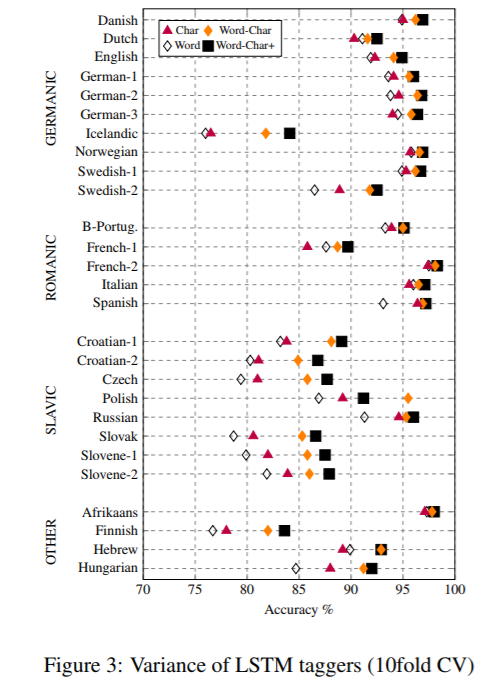


The CLTK project develops NLP tools for dead languages.  Annotated corpora for these, when available, are sometimes relaively small.  For [Old English](http://www.oldenglishaerobics.net/resources/magic_letter.pdf) (OE, a Germanic language), for example, the [ISWOC Treebank](http://iswoc.github.io/), contains only 28,300 tokens, so half or less of the recommended minimum.  The question therefore arises of whether the performance observed for Germanic languages, in the range of 90%-96+% accuracy, can be reproduced.

Note the odd low outliter accuracy scores turned in by Icelandic.  It is relevant here because Icelandic is the modern language closest to OE, also because of its orthography: like OE, the Icelandic alphabet contains the letters ash, eth, thorn. 

That's the problem part.  The opportunity lies in the fact that the ISWOC annotations provide much more than mere POS tags.  Instead, each word is assigned values over an extensive set of morphological features.  These are listed in the XML for each annotated text:

Two questions arise:
1.  Can we use these annotations to construct a single classifier that outputs *all* morphosyntactic features, in addition to the category feature (POS tag)?
2.  Is it just possible that the complete morphological analysis may help the individual task, e.g. POS tagging?

Let's get started.

## Baseline

### Dataset

The ISWOC treebank contains a few OE "books" that have been mostly annotated, for a total of 28,300 tokens.  The book construct provides a useful unit for splitting the dataset, because each distinct book is likely to contain idionyscratic words.  That is, by training on one set of books and testing on another, it is likely that out-of-vocabulary (OOV) tokens will occur in the test set.

We reserve one book, an Anglo-Saxon translation of Orosius' *Histories*,  as a test set (1701 tokens), while the rest form the wraining set.

### NLTK Perceptron training

Horsmann and Zesch use a conditional random fields (CRF) tagger as the baseline.  I have found that NLTK's [Perceptron tagger](http://www.nltk.org/_modules/nltk/tag/perceptron.html) to be more accurate (if somewhat slower) than the CRF tagger, so I use it here.

The following output shows, for each of the morphological features above, the performance of a separately-trained Perceptron classifer.  The following statistics are given: 10-fold CV, accuracy and Cohen's Kappa on the test set, a confusion matrix, and time to tag *Beowulf*.

Because tokens are often unvalued for some of the features (e.g. tense), raw accuracy can be misleading.  Kappa statistics are more useful in these cases.

The 10-fold CV accuracy for POS tagging is 92%, placing the tagger in the general range of the Germanic LSTM-based approaches considered by Horsmann and Zesch. 

Test accuracy for POS tagging is considerably lower, at 84%, likely because of OOV terms.  The question then is whether this score can be improved upon. End users are likely to require at least 90% accuracy -- likely a lot more!

## The boring bits ...
### Character-level representation

One of the inputs into the model described below consists of words in sentences represented as indices into an alphabet of letters.

Script files for downloading and preprocessing the ISWOC treebank are available as part of the [old_english_models_cltk](https://github.com/cltk/old_english_models_cltk) repository.

Let's load the sentences in the full set, along with their tags:

In [1]:
import numpy as np

def load_corpus(filename, tagged=True):
    with open(filename, "r") as f:
        sentences = []
        words = {}
        for line in f:
            sentence = []
            pairs = line.rstrip('\n').split(' ')
            for pair in pairs:
                if pair != '':
                    if tagged == True:
                        word, tag = pair.split('/')
                        sentence.append((word, tag))
                        words[(word, tag)] = words.get((word, tag), 0) + 1                    
                    else:
                        sentence.append(pair)
                        words[pair] = words.get(pair, 0) + 1
            sentences.append(sentence)


        return words, sentences

In [2]:
words, sents = load_corpus('../corpora/oe/oe.all_features')

Sentences are just lists of (token, taglist) pairs, where a taglist is the concatenation of all morphosyntactic features for the word.

In [3]:
sents[:10]

[[('Mæg', 'V-3spi-----i'),
  ('gehyran', 'V----n-----n'),
  ('se', 'Pd-s---mn--i'),
  ('ðe', 'G----------n'),
  ('wyle', 'V-3spx-----i'),
  ('be', 'R----------n'),
  ('þam', 'Pd-s---nd--i'),
  ('halgan', 'A--s---ndpwi'),
  ('mædene', 'Nb-s---nd--i'),
  ('Eugenian', 'Ne-s---fd--i'),
  ('Philyppus', 'Ne-s---mg--i'),
  ('dæhter', 'Nb-s---fd--i'),
  ('hu', 'Du---------n'),
  ('heo', 'Pp3s---fn--i'),
  ('ðurh', 'R----------n'),
  ('mægðhad', 'Nb-s---ma--i'),
  ('mærlice', 'Df-------p-i'),
  ('þeah', 'V-3sui-----i'),
  ('and', 'C----------n'),
  ('þurh', 'R----------n'),
  ('martyrdom', 'Nb-s---ma--i'),
  ('þisne', 'Pd-s---ma--i'),
  ('middaneard', 'Nb-s---ma--i'),
  ('oferswað', 'V-xxui-----i')],
 [('Sum', 'Py-s---mnpsi'),
  ('æþelboren', 'A--s---mnpsi'),
  ('þægn', 'Nb-s---mn--i'),
  ('wæs', 'V-3sui-----i'),
  ('Philippus', 'Ne-s---mn--i'),
  ('gehaten', 'V--xup-xx-ti'),
  ('ðone', 'Pd-s---ma--i'),
  ('asende', 'V-3spx-----i'),
  ('se', 'Pd-s---mn--i'),
  ('casere', 'Nb-s---mn--i'),
  ('Co

First we need the complete alphabet for the orthography.  In passing we'll get the maximum word length in the corpus.

In [4]:
def build_alphabet(words):
    alphabet = {}
    max_word_len = 0
    
    for word in words:
        max_word_len = max(len(word), max_word_len)
        for letter in word:
            alphabet[letter] = alphabet.get(letter, 0) + 1
            
    return list(alphabet.keys()), max_word_len

In [6]:
alpha, max_word_len = build_alphabet([word for word,_ in words.keys()])
max_word_len

18

We will use a shorter word length to avoid too many zeros in the representations.

In this exploration we will not limit the size of the sentence (maximum number of words in sentence) because we want to use *all* the training data.  Instead, we will rely on Keras's masking to remove empty word and letter slots from the computation.

In [77]:
max_word_len = 12
lengths = np.sort([len(sent) for sent in sents])
length, count = np.unique(lens, return_counts=True)
dict(zip(length, count))
max_sent_len = 48

Now we convert the textual representation of tokens into vectors of indices into the alphabet, and break up the feature string into distinct sets of one-shot vectors representing the output.

In [9]:
from keras.utils.np_utils import to_categorical

feature_names = ['pos', 'person', 'number', 'tense', 'mood', 'voice', 'gender', 'case', 'degree', 'strength', 'inflection']

def indexify(string_list):
    vocab = list(set(string_list))
    return np.asarray([vocab.index(elem)+1 for elem in string_list]), vocab

def convert_morphology(tagged_words):
    slicers = [(0,2),2,3,4,5,6,7,8,9,10,11]
    feature_tags = [[] for _ in slicers]
    
    for _, tag in tagged_words:
        for i, slicer in enumerate(slicers):
            start, end = slicer if type(slicer) == tuple else (slicer, slicer + 1)
            feature_tags[i].append(tag[start:end])
        
    vectors = []
    label_sets = []
    indices = []
    for feature in feature_tags:
        idx, labels = indexify(feature)
        label_sets.append(labels)
        indices.append(idx)
        vectors.append(to_categorical(idx))
        
    return vectors, label_sets, indices

/home/jds/tensorflow-gpu/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [293]:
def select_letter_indices(word, alphabet, max_word_len):
    v = np.zeros((max_word_len))
    
    for i in range(min(len(word), max_word_len)):
        v[i] = alphabet.index(word[i]) + 1 if word[i] in alphabet else 0
        
    return v
    
def create_char_dataset(tagged_words, sentences, alphabet, max_sent_len, max_word_len):
    num_sentences = len(sentences)
    X = np.zeros((num_sentences, max_sent_len, max_word_len), dtype='int32')
    
    tagged_tokens = []
    for i, sent in enumerate(sentences):
        sent_len = len(sent)
        for j, (word, tag) in enumerate(sent):
            if j >= max_sent_len:
                break
            tagged_tokens.append((word, tag))
            X[i, j, :] = select_letter_indices(word, alphabet, max_word_len)
        
    features, labels, _ = convert_morphology(tagged_tokens)
    
    Y = [np.zeros((num_sentences, max_sent_len, F.shape[1])) for F in features]
    i = 0
    for j, sent in enumerate(sentences):
        for k in range(min(max_sent_len, len(sent))):
            for f in range(len(features)):
                Y[f][j, k, :] = features[f][i]
            i += 1

    return X, Y, labels, tagged_tokens

In [78]:
X, Y, labels, _ = create_char_dataset(words, sents, alpha, max_sent_len, max_word_len)

The input is a 3D tensor of dimensions (sentences, words, letters), and the output a list of 3D tensors of dimensions (sentences, words, one-shot-vector), one per feature (POS, case, etc.)

In [79]:
X.shape, Y[0].shape

((2536, 48, 12), (2536, 48, 19))

Now we split the datasets into training and test sets.  The last 110 sentences of the corpus correspond to the Orosius text.

In [80]:
X_test, Y_test = X[-110:], [y[-110:] for y in Y]
X = X[:-110]
Y = [y[:-110] for y in Y]

### Semantic vectors for words

The second input consists of word2vec vectors representing the semantics of whole words.  The vectors were previously computed using the well-known skipgram + negative sampling method.

Let's load the vocabulary and create forward and reverse indices.

In [59]:
def load_vocab(filename):
    vocab = {}
    rev_vocab = {}
    
    with open('oe_types.txt', 'r') as f:
        for pair in f:
            idx, word = pair.split()
            vocab[word] = int(idx)
            rev_vocab[int(idx)] = word
            
    return vocab, rev_vocab

In [60]:
vocab, rev_vocab = load_vocab('models/oe/oe_types.txt')

The vectors were computed using OE text found online.  All of the ISWOC corpus texts are included in this larger corpus, so there will be zero OOV terms during training and evaluation.

In [61]:
len(vocab)

325198

Next, we load and normalize the vectors themselves.  The zeroeth vector contains zeros, for empty word slots in sentences, and thus supporing Keras masking.

In [17]:
import pickle

def load_vectors(filename):
    with open('oe_vectors.bin', 'rb') as f:
        vectors = pickle.load(f)
        
    vectors = np.concatenate([np.zeros((1,300)),vectors],axis=0)
    norm_vectors = np.divide(vectors, np.linalg.norm(vectors, axis=-1, keepdims=True))
    norm_vectors[0] = 0
    
    return norm_vectors

In [18]:
vectors = load_vectors('models/oe/oe_vectors.bin')

/home/jds/tensorflow-gpu/lib/python3.5/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


Finally, we indexify the text into the vocabulary, thus linking the input sentences to entries in the vector table.  The latter will get loaded into a Keras embedding matrix.

In [212]:
def create_word_dataset(sentences, vocab, max_sent_len):
    X = np.zeros((len(sentences), max_sent_len))
    for i, sent in enumerate(sentences):
        for j, (word, _) in enumerate(sent):
            if j == max_sent_len:
                break
            X[i,j] = vocab[word]
            
    return X

In [81]:
X2 = create_word_dataset(sents, vocab, max_sent_len)
X2_train = X2[:-110]
X2_test = X2[-110:]

## The Model

Now we can look at the model.  It is worth noting that the model presented here is the result of a long search over possible approaches, including various mixes of convolutional and recurrent networks, including encoder-decoder setups, inception convents with attention, character-only, word-only, and more.  

Which is hardly to say this is the *best* approach; just the one that so far has worked best for the specific problem of morphological analysis of OE using the ISWOC data set.

### The basic idea

1.  We have two embedding matrices: one, entirely trained from random initialization, representing characters; the other representing semantic word vectors.  The latter is not trained.
2.  The character vectors are each fed to a character Bi-LSTM, to yield a vector per word.
3.  The output of the character Bi-LSTMs are input to a second Bi-LSTM, that again yields a vector per word.  That is, the activation of the LSTM at each time step is kept.
4.  The word2vec vectors for a sentence are fed to a third Bi-LSTM, that again yields a vector per word.
5.  The outputs of steps 3 and 4 are concatenated for each word.
6.  The concatenated vectors are passed through three fully-connected feedforward layers.
7.  A sepearate softmax layer, one per feature, is then run over the result of step 6.

This model is roughly comparable to the Word+Char model tested by Horsmann and Zesch.

Note 1: One *could* use convolutions for processing the character-level information.  The trouble is that Keras convolutional networks do not support masking, while RNNs do.  Hence that use of RNNs throughout.

Note 2: LSTMs tend to overfit easily, hence the aggressive use of regularization in the LSTM layers.


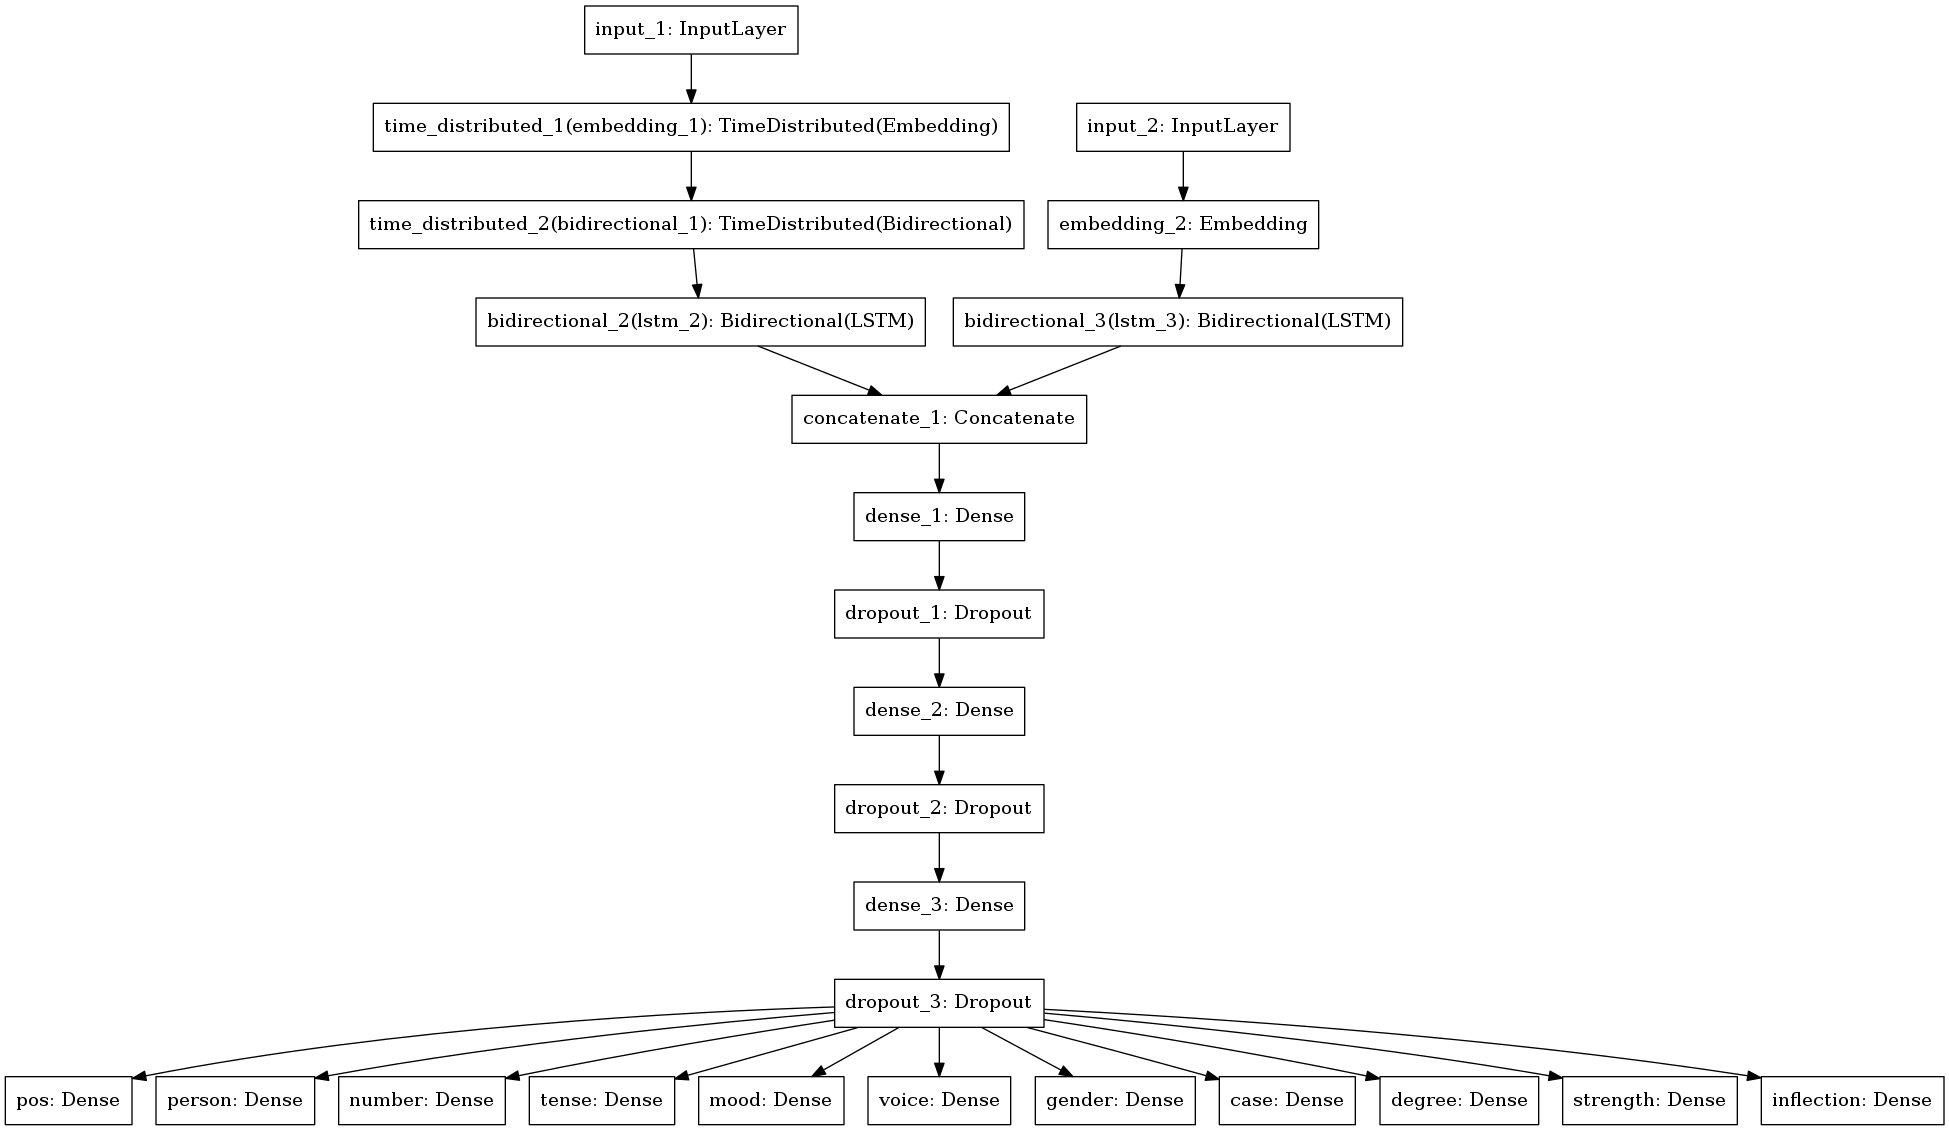

In [64]:
from keras import layers, Input
from keras.models import Model
from keras import regularizers
import keras.backend as K

def make_char_word_rnn_model(
    word_vectors,
    alphabet_size, 
    char_vector_width, 
    max_sent_len,
    max_word_len, 
    char_lstm_size,
    word_lstm_size,
    morpho_sizes,
    morpho_names,
    dense_size):
    
    
    # The Char portion
    # sub-word features
    char_embed = layers.Embedding(alphabet_size + 1,
                             char_vector_width,
                             input_length = max_word_len,
                             trainable = True,
                             mask_zero = True)  
    
    def _word_analyzer_rnn(kernel_size):
        rnn_layer = layers.Bidirectional(layers.LSTM(kernel_size, activation='tanh', dropout=0.2, recurrent_dropout=0.2))
        return rnn_layer
    
    # encode the input
    char_input = Input(shape=(max_sent_len, max_word_len, ), dtype='float32')
    vectors = layers.TimeDistributed(char_embed)(char_input)
    
    # run word-level RNNs over the letters
    word_rnn = _word_analyzer_rnn(char_lstm_size)
    rnn_blocks = layers.TimeDistributed(word_rnn)(vectors)
   
    # now run the sentence LSTM
    char_lstm = layers.Bidirectional(layers.LSTM(word_lstm_size, return_sequences=True, 
                                                 name='char_encoder',
                                                 activation='tanh', 
                                                 kernel_regularizer=regularizers.l2(0.01),
                                                 activity_regularizer=regularizers.l2(0.01),
                                                 dropout=0.4, recurrent_dropout=0.4))(rnn_blocks)
    
    # The Word portion
    # word vectors
    word_embed = layers.Embedding(word_vectors.shape[0],
                                  word_vectors.shape[1],
                                  input_length=max_sent_len,
                                  weights=[word_vectors],
                                  trainable = False,
                                  mask_zero = True)
    
    word_input = Input(shape=(max_sent_len,), dtype='float32')
    word_vectors = word_embed(word_input)
    
    word_lstm = layers.Bidirectional(layers.LSTM(word_lstm_size, return_sequences=True, 
                                                 name='word_encoder',
                                                 activation='tanh',
                                                 kernel_regularizer=regularizers.l2(0.01),
                                                 activity_regularizer=regularizers.l2(0.01),
                                                 dropout=0.4, recurrent_dropout=0.4))(word_vectors)
    
    concat = layers.concatenate([char_lstm, word_lstm], axis=-1)
    
    out = layers.Dense(dense_size, activation='relu')(concat)
    out = layers.Dropout(rate=0.2)(out)
    out = layers.Dense(dense_size, activation='relu')(out)
    out = layers.Dropout(rate=0.2)(out)
    out = layers.Dense(dense_size, activation='relu')(out)
    out = layers.Dropout(rate=0.2)(out)
    
    outputs = [layers.Dense(morpho_size, activation='softmax', name=morpho_names[i])(out) for i, morpho_size in enumerate(morpho_sizes)]

    
    model = Model([char_input, word_input], outputs)

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
    
    
    return model

In [89]:
K.clear_session()
m1 = make_char_word_rnn_model(vectors, len(alpha), 
                              60, max_sent_len, max_word_len,
                              100, 100,
                              [y.shape[2] for y in Y],
                              feature_names,
                              200)
m1.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 48, 12)       0                                            
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, 48, 12, 60)   3540        input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 48)           0                                            
__________________________________________________________________________________________________
time_distributed_2 (TimeDistrib (None, 48, 200)      128800      time_distributed_1[0][0]         
__________________________________________________________________________________________________
embedding_

A callback will help visualize the training process.  Three plots will be produced:

1.  Training and validation losses.
2.  Training accuracy for each feature type.
3.  Validation accuracy for each feature type. 

In [83]:
from matplotlib import pyplot as plt
from IPython.display import clear_output


class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.accs = {}
        self.val_accs = {}
        for f in feature_names:
            self.accs[f] = []
            self.val_accs[f] = []
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        
        for f in feature_names:
            self.accs[f].append(logs.get(f + '_acc'))
            self.val_accs[f].append(logs.get('val_' + f + '_acc'))
        self.i += 1
        
        clear_output(wait=True)
        _, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=True, figsize=(20, 10))
        ax1.plot(self.x, self.losses, label="loss")
        ax1.plot(self.x, self.val_losses, label="val_loss")
        
        for f in feature_names:
            ax2.plot(self.x, self.accs[f], label=(f + "_acc"))
            ax3.plot(self.x, self.val_accs[f], label="val_" + f + "_acc")
            
        ax1.legend()
        ax2.legend()
        ax3.legend()
        plt.show();
        
        for f in feature_names:
            print(f +  " best:", np.round(np.max(self.val_accs[f]), 3), "last:", np.round(self.val_accs[f][-1], 3))
        
plot_losses = PlotLosses()

Now we are ready to train the model.  A smaller batch-size seems to work earlier on, though in a careful training regime it emerges that increasing the batch size later yields slightly higher test accuracy.

We will split the training dataset again 95/05 so that a validation ("dev") set will provide information about the fitting process.


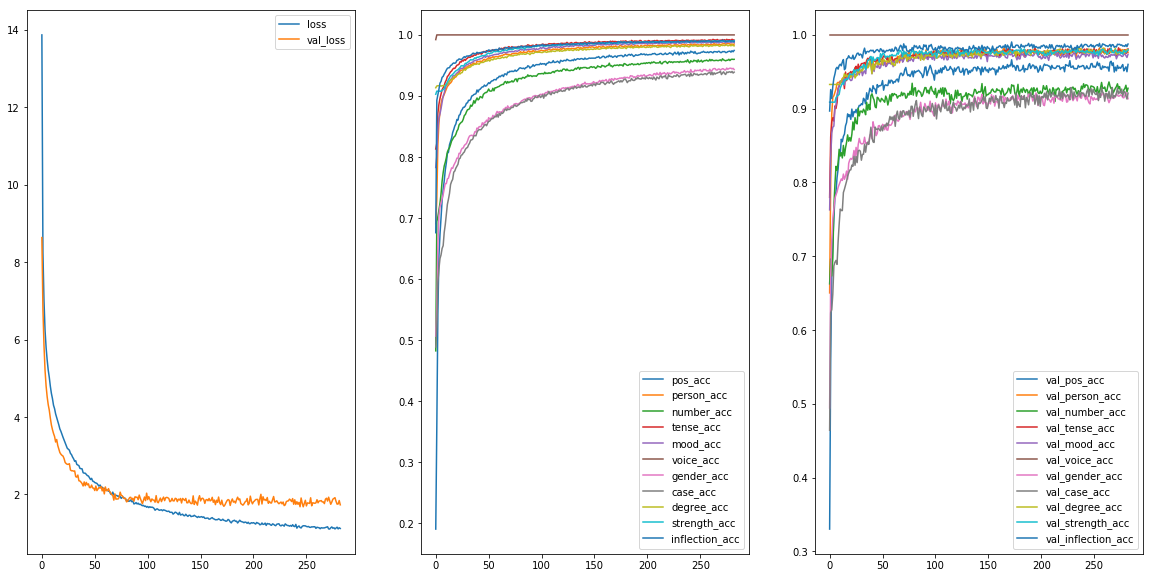

pos best: 0.966 last: 0.96
person best: 0.983 last: 0.976
number best: 0.936 last: 0.928
tense best: 0.983 last: 0.981
mood best: 0.978 last: 0.974
voice best: 1.0 last: 1.0
gender best: 0.922 last: 0.914
case best: 0.929 last: 0.921
degree best: 0.983 last: 0.979
strength best: 0.982 last: 0.98
inflection best: 0.99 last: 0.988
Epoch 284/300
1360/2304 [================>.............] - ETA: 46s - loss: 1.0843 - pos_loss: 0.0797 - person_loss: 0.0441 - number_loss: 0.1130 - tense_loss: 0.0244 - mood_loss: 0.0347 - voice_loss: 1.2708e-07 - gender_loss: 0.1549 - case_loss: 0.1694 - degree_loss: 0.0475 - strength_loss: 0.0257 - inflection_loss: 0.0291 - pos_acc: 0.9737 - person_acc: 0.9856 - number_acc: 0.9592 - tense_acc: 0.9913 - mood_acc: 0.9874 - voice_acc: 1.0000 - gender_acc: 0.9477 - case_acc: 0.9405 - degree_acc: 0.9844 - strength_acc: 0.9908 - inflection_acc: 0.9900

In [ ]:
history = m1.fit([X, X2_train], [y for y in Y],
                 batch_size=16, epochs=300,
                 callbacks=[plot_losses],
                 validation_split = 0.05)

## Results

Let's evaluate the model against the test set, the same that was used in evaluating the Perceptron tagger above.

In [104]:
dict(zip(feature_names, np.round(m1.evaluate([X_test, X2_test], [y for y in  Y_test], batch_size=256)[-11:], 3)))

110/110 [==============================] - 1s 6ms/step


{'case': 0.858,
 'degree': 0.935,
 'gender': 0.858,
 'inflection': 0.965,
 'mood': 0.967,
 'number': 0.91,
 'person': 0.979,
 'pos': 0.918,
 'strength': 0.954,
 'tense': 0.979,
 'voice': 1.0}

Comparing this result to the Perceptron tagger above, we see that the Word+Char model improves on NLTK's AveragedPerceptron across all features, and especially so for the POS tagging task.  

The POS accuracy of 0.918 puts the Word+Char in the range of the Germanic taggers tested by Horsmann and Zesch, though somewhat on the lower end.

| Feature | Perceptron Tagger | Word+Char LSTM | Diff |
----------|-------------------|----------------|------|
|  POS | 0.840 | 0.918 | + 7.8% |
| Person | 0.956 | 0.979 | + 2.3% |
| Number | 0.827 | 0.91 | + 9.3% |
| Tense | 0.960 | 0.979 | + 3.9% |
| Mood | 0.952 | 0.967 | + 1.5% |
| Gender | 0.798 | 0.858 | + 6.0% |
| Case | 0.814 | 0.858 | + 4.4 % |
| Degree | 0.907 | 0.935 | + 2.8% |
| Strength | 0.927 | 0.954 | + 2.7% |
| Inflection | 0.931 | 0.965 | + 3.4% |

### Error Analysis

In [153]:
labels_full = [
    ['interrogative adverb', 'quantifier', 'foreign word','conjunction','possessive pronoun', 'personal pronoun',
     'inifnitive marker','subjunction','adverb','interrogative pronoun',
     'adjective','indefinite pronoun','verb','interjection',
     'proper noun','preposition','common noun','demonstrative pronoun'],
    ['second person', 'third person', 'none', 'first person', 'uncertain person'],
    ['dual', 'none', 'singular', 'plural', 'uncertain number'],
    ['past', 'none', 'present'],
    ['imperative', 'none', 'subjunctive', 'participle', 'infinitive','uncertain mood', 'indicative'],
    ['none'],
    ['masculine', 'feminine', 'none', 'masculine or feminine', 'masculine or neuter', 'neuter', 'uncertain gender', 'feminine or neuter', 'masculine, feminine or neuter'],
    ['none', 'oblique', 'accusative', 'nominative', 'dative', 'genitive', 'uncertain case', 'no case', 'instrumental'],
    ['comparative', 'none', 'superlative', 'positive', 'uncertain degree' ,'no degree'],
    ['weak or strong' ,'weak', 'none', 'strong'],
    ['non-inflecting', 'inflecting']
]

In [154]:
from nltk.metrics import ConfusionMatrix

predicted = m1.predict([X_test, X2_test])

for i in range(len(predicted)):
    print('---------------- ', feature_names[i], ' ----------------')
    gold = np.ndarray.flatten(np.argmax(Y_test[i], axis=2))
    mask = gold > 0
    pred = np.ndarray.flatten(np.argmax(predicted[i], axis=2))
    
    gold_labels = [labels_full[i][idx-1] for idx in gold[mask]]
    pred_labels = [labels_full[i][idx-1] for idx in pred[mask]]
    print(ConfusionMatrix(gold_labels, pred_labels))

----------------  pos  ----------------
                      |                   d           i                             |
                      |                   e       i   n                             |
                      |                   m       n   t                             |
                      |                   o   i   t   e       p                     |
                      |                   n   n   e   r       o                     |
                      |                   s   d   r   r   p   s                     |
                      |                   t   e   r   o   e   s                     |
                      |                   r   f   o   g   r   e                     |
                      |                   a   i   g   a   s   s                     |
                      |                   t   n   a   t   o   s                     |
                      |           c   c   i   i   t   i   n   i   p   p       s     |
              

A few considerations:

* POS tagging, there is some equivocation between adjectives and nouns, perhaps explained by the observation that in OE adjectives are inflected like nouns for case, gender, number.  Also, because of its relatively free word order, adjectives are not predictable pre- or post-nominal or in predicate position.
* Another issue for POS tagging is the "subjunction" annotation, which the tagger frequently mis-tags as adverbial.  These "subjuction" elements appear to be complementizers, such as *þy* "therefore, because", which might rightly be tagged as adverbial, i.e. merged in A-bar positions.
* Forms annotated as quantifiers are tagged as adjectives by the classifier.  This again is linguistically defensible, as words like *micel* "much, big, a lot" and *manig* "many" are sometimes classed as adjectives (e.g. by [Wiktionary](https://en.wiktionary.org/wiki/manig))
* As for case, there is a predictable equivocation between nominative and accusative case assignment.  This is due to syncretism in OE's case system: nominative and accusative forms overlap in cells of the nominal and adjectival paradigms -- principally in masculine and neuter lemmas --, and since word order is only weakly driven by syntax, disambiguation is difficult.
* The last point might also explain the system's lack of accuracy in distinguishing masculine from neuter forms. Its apparent difficulty in distinguishing feminine from masculine forms likely lies in the phonological heterogeneity of the categories: on encountering a new word, it is difficult to guess at its gender from its form.


## Productification

To be useful in practice, the model parameters must be exported, and the preprocessing routines wrappend in a library.

### Saving and loading


In [275]:
import pickle

def save_morpho_model(path, model, alphabet, feature_names, labels):
    model.save(path + "/" + 'morpho_model.h5')
        
    with open(path + '/' + 'alphabet.pickle', 'wb') as out:
        pickle.dump(alphabet, out)
        
    with open(path + '/' + 'feature_names.pickle', 'wb') as out:
        pickle.dump(feature_names, out)
    
    with open(path + '/' + 'labels.pickle', 'wb') as out:
        pickle.dump(labels, out)
    

In [274]:
save_morpho_model('../models/oe', m1, alpha, feature_names, labels_full)

The loading of the model, the preprocessing and the tagging are best wrapped into a class.

In [328]:
class MorphologicalAnalyzer:
    def __init__(self, path):
        """Loads the model from a saved HDF5 file,
        along with related data structures for taglibs and vocabularies."""
        
        self.model = load_model(path + '/' + 'morpho_model.h5')

        with open(path + '/' + 'alphabet.pickle', 'rb') as inp:
            self.alphabet = pickle.load(inp)

        with open(path + '/' + 'feature_names.pickle', 'rb') as inp:
            self.feature_names = pickle.load(inp)

        with open(path + '/' + 'labels.pickle', 'rb') as inp:
            self.labels = pickle.load(inp)

        input_layer = self.model.get_layer(index=0)

        self.max_sent_len = input_layer.input_shape[1]
        self.max_word_len = input_layer.input_shape[2]
        
        self.vocab = {}
        with open(path + '/' + 'oe_types.txt', 'r') as f:
            for pair in f:
                idx, word = pair.split()
                self.vocab[word] = int(idx)
                
        
    def _select_letter_indices(self, word):
        """For an input words, returns a vector of indices into the alphabet."""
        v = np.zeros((self.max_word_len))
    
        for i in range(min(len(word), self.max_word_len)):
            v[i] = self.alphabet.index(word[i]) + 1 if word[i] in self.alphabet else 0

        return v
        
    def _characterize(self, sentences):
        """For a list of sentences, returns a tensor of dimension 
        (num sentences, words_per_sentence, letters_per_word)
        of indices into the alphabet."""
        
        X = np.zeros((len(sentences), self.max_sent_len, self.max_word_len), dtype='int32')
    
        for i, sent in enumerate(sentences):
            for j, word in enumerate(sent):
                if j >= self.max_sent_len:
                    break
                X[i, j, :] = self._select_letter_indices(word)

        return X
    
    def _wordize(self, sentences):
        """For a list of sentences, returns a tensor of dimension
        (num_sentences, words_per_sentence)
        of indices into the vocabulary."""
        
        X = np.zeros((len(sentences), self.max_sent_len))
        for i, sent in enumerate(sentences):
            for j, word in enumerate(sent):
                if j == self.max_sent_len:
                    break
                X[i,j] = self.vocab[word] + 1 if word in self. vocab else 0

        return X
    
    def preprocess(self, text):
        """Tokenizes a text into sentences and words (list of list of strings) if necessary,
        and maps the tokens to indices into the vocabulary and the alphabet,
        returning a 3D tensor for the characters and 2D tensor for the words."""
        
        if type(text) != list:
            text = text.replace('!','.') 
            text = text.replace(',', ' ')
            sents = [word_tokenize(sent) for sent in sent_tokenize(text)]
        else:
            sents = text
        
        X1 = self._characterize(sents)
        X2 = self._wordize(sents)
        
        return sents, X1, X2
        
    def tag(self, text):
        """Takes a text as a string or a list of list of string tokens,
        returning a list of list of tuples (word, feature_bundle),
        where feature_bundle is a dict of feature to feature_value."""
        
        sentences, X1, X2 = self.preprocess(text)
        pred = self.model.predict([X1, X2], verbose=1, batch_size=2048)
        tagged_sents = []

        for i, sent in enumerate(sentences):
            tagged_sent = []
            for j, word in enumerate(sent):
                if j == self.max_sent_len:
                    break
                feature_bundle = {}
                for k, feature_name in enumerate(self.feature_names):
                    feature_value = self.labels[k][np.argmax(pred[k][i,j])-1]
                    if feature_value != 'none':
                        feature_bundle[feature_name] = feature_value
                tagged_sent.append((word, feature_bundle))
            tagged_sents.append(tagged_sent)
        
        return tagged_sents

In [332]:
import time
start_time = time.time()
morph_anal = MorphologicalAnalyzer('../models/oe')
print("---- {0} seconds ----".format(time.time() - start_time))

---- 29.164775371551514 seconds ----


In [334]:
_,everything = load_corpus('../texts/oe/oe_all.txt', tagged=False)

In [335]:
start_time = time.time()
tags = morph_anal.tag(everything)
print("---- {0} seconds ----".format(time.time() - start_time))

110656/110656 [==============================] - 54s 485us/step
---- 104.75169515609741 seconds ----


105 seconds for about 1.5MM words translates to a rate of ~ 145,000 words/sec.  This compares favourably with the ~10,000 words/sec for just one feaature (POS) turned in by the Perceptron tagger.  Of course the hardware plays a huge role here: I'm using a GTX 1080Ti to accelerate the tensorflow computation. 

In [331]:
tags[0]

[('Us',
  {'inflection': 'inflecting',
   'number': 'singular',
   'person': 'first person',
   'pos': 'personal pronoun'}),
 ('is',
  {'inflection': 'inflecting',
   'mood': 'indicative',
   'number': 'singular',
   'person': 'third person',
   'pos': 'verb',
   'tense': 'present'}),
 ('riht', {'degree': 'positive', 'inflection': 'inflecting', 'pos': 'adverb'}),
 ('micel',
  {'case': 'nominative',
   'degree': 'positive',
   'gender': 'neuter',
   'inflection': 'inflecting',
   'number': 'singular',
   'pos': 'quantifier',
   'strength': 'strong'}),
 ('ðæt', {'inflection': 'non-inflecting', 'pos': 'subjunction'}),
 ('we',
  {'case': 'nominative',
   'inflection': 'inflecting',
   'number': 'plural',
   'person': 'first person',
   'pos': 'personal pronoun'}),
 ('rodera',
  {'case': 'genitive',
   'gender': 'masculine',
   'inflection': 'inflecting',
   'number': 'plural',
   'pos': 'common noun'}),
 ('weard,',
  {'degree': 'positive',
   'gender': 'neuter',
   'inflection': 'inflectin